# SubOcean Profile Processing Example
Process a real SubOcean profile using the preprocessing pipeline

In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Add src to path
src_dir = Path.cwd().parent / 'src'
sys.path.append(str(src_dir))

from core.profile import Profile
from preprocessing.cleaner import DataCleaner
from preprocessing.rsd_processor import RSDProcessor
from preprocessing.error_handler import ErrorHandler

In [2]:
# Load profile data
data_path = Path('../data/Level0/SubOceanExperiment2024-11-27T12-58-44.txt')
log_path = Path('../data/Level0/SubOceanExperiment2024-11-27T12-58-44.log')

profile = Profile(data_path, log_path)
data, metadata = profile.load()

print(f"Loaded {len(data)} measurements")
print(f"Profile start: {metadata.start_time}")
print(f"Profile end: {metadata.end_time}")

Loaded 2789 measurements
Profile start: 2024-11-27 12:58:44
Profile end: 2024-11-27 13:45:20


In [3]:
# Process data
# 1. Clean measurements
cleaner = DataCleaner(data)
# Use custom ranges
custom_ranges = {
    'Cavity Pressure (mbar)': (29.0, 31.0),
    'Depth (meter)': (-5, 15000)
}
result = cleaner.validate_measurements(validation_ranges=custom_ranges)
cleaned_data = cleaner.clean_h2o_measurements(window=5)

# 2. Process RSD
processor = RSDProcessor(cleaned_data)
rsd = processor.calculate_rsd('CH4')
filtered_data = processor.filter_by_threshold('CH4', threshold=0.00001)

# 3. Handle errors
handler = ErrorHandler()
final_data = handler.process_error_standard(filtered_data)
metrics = handler.get_quality_metrics(final_data)

print("Quality Metrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.6f}")

Quality Metrics:
error_std_mean: 0.003917
error_std_std: 0.000778
missing_data_pct: 2.199851


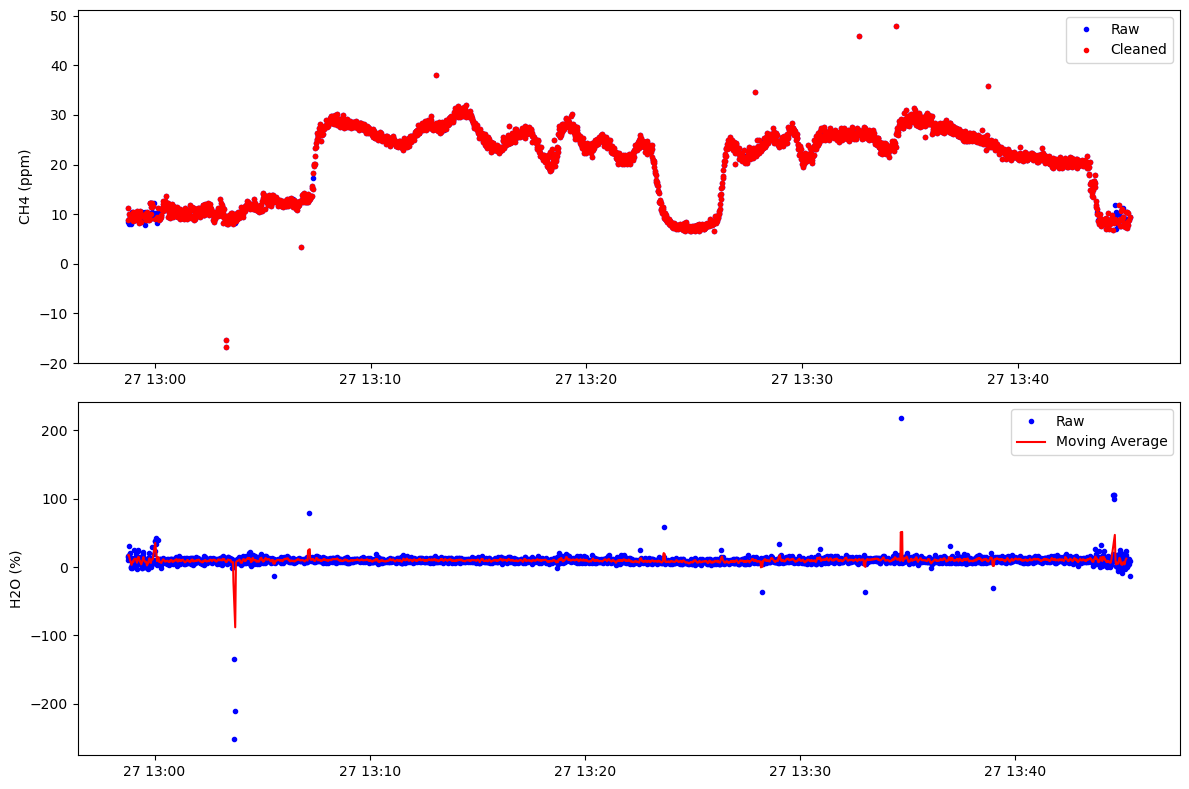

In [4]:
# Visualize results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot CH4 concentration
ax1.plot(data['datetime'], data['[CH4] dissolved with water vapour (ppm)'], 'b.', label='Raw')
ax1.plot(final_data['datetime'], final_data['[CH4] dissolved with water vapour (ppm)'], 'r.', label='Cleaned')
ax1.set_ylabel('CH4 (ppm)')
ax1.legend()

# Plot H2O with moving average
ax2.plot(data['datetime'], data['[H2O] measured (%)'], 'b.', label='Raw')
ax2.plot(final_data['datetime'], final_data['[H2O] measured (%)_ma'], 'r-', label='Moving Average')
ax2.set_ylabel('H2O (%)')
ax2.legend()

plt.tight_layout()
plt.show()